In [1]:
import numpy as np
#import scipy.linalg as spla
#import scipy.fftpack as fp
#import scipy.optimize as so
#import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')
#rcParams['xtick.direction'] = 'in'
#rcParams['ytick.direction'] = 'in'

In [2]:
np.random.seed(1)

In [3]:
## Parameters

n_agents = 16
n_clusters = 4
rho = 0.5
w_disp = 4.

dt = 0.01
sim_time = 60.
n_it = int(sim_time / dt)

In [4]:
## Init vals

ww = np.array([0.1, 0.2, 0.3, 0.4])
w_nat = np.concatenate(((1 * w_disp + ww), (2 * w_disp + ww), (3 * w_disp + ww), (4 * w_disp + ww)))
theta_0 = 2 * np.pi * np.random.rand(n_agents)
mu = np.tile(np.arange(1, 5) / 4, 4) * 2.5
f0_clust = np.random.rand(n_clusters)
f0 = np.zeros((n_agents)) + 0.5
f0[0:4] = f0[0:4] * f0_clust[0]
f0[4:8] = f0[4:8] * f0_clust[1]
f0[8:12] = f0[8:12] * f0_clust[2]
f0[12:16] = f0[12:16] * f0_clust[3]

print(w_nat)
print(mu)
print(f0)

[ 4.1  4.2  4.3  4.4  8.1  8.2  8.3  8.4 12.1 12.2 12.3 12.4 16.1 16.2
 16.3 16.4]
[0.625 1.25  1.875 2.5   0.625 1.25  1.875 2.5   0.625 1.25  1.875 2.5
 0.625 1.25  1.875 2.5  ]
[0.2086524  0.2086524  0.2086524  0.2086524  0.27934491 0.27934491
 0.27934491 0.27934491 0.07019347 0.07019347 0.07019347 0.07019347
 0.09905074 0.09905074 0.09905074 0.09905074]


In [5]:
## Progress recording

thetas = np.zeros((n_agents, n_it))
thetas_dot = np.zeros_like(thetas)
time_vals = np.linspace(0., sim_time, n_it)

In [6]:
## Adjacency matrix

adj_mat = np.zeros((n_agents, n_agents), dtype=np.float32)

# 1st cluster
adj_mat[0, 3] = 1.
adj_mat[1, 0] = 1.
adj_mat[2, 1] = 1.
adj_mat[3, 2] = 1.
adj_mat[3, 4] = 1.

# 2nd cluster
adj_mat[0+4, 3+4] = 1.
adj_mat[1+4, 0+4] = 1.
adj_mat[2+4, 1+4] = 1.
adj_mat[3+4, 2+4] = 1.
adj_mat[6, 11] = 1.

# 3rd cluster
adj_mat[0+8, 3+8] = 1.
adj_mat[1+8, 0+8] = 1.
adj_mat[2+8, 1+8] = 1.
adj_mat[3+8, 2+8] = 1.
adj_mat[9, 14] = 1.

# 4th cluster
adj_mat[0+12, 3+12] = 1.
adj_mat[1+12, 0+12] = 1.
adj_mat[2+12, 1+12] = 1.
adj_mat[3+12, 2+12] = 1.
adj_mat[12, 1] = 1.

In [7]:
## Start loop

theta = theta_0
for ittt in range(n_it):
    # sum of sins
    theta_mat = np.repeat(theta.reshape(n_agents, 1), n_agents, axis=1)
    diffs = theta_mat.T - theta_mat
    sins = np.sin(diffs)
    sins = adj_mat * sins
    sums_sins = np.sum(sins, axis=1)
    sums_diffs = np.sum(diffs, axis=1)
    
    if ittt >= n_it//3:
        theta_new = theta + dt * (w_nat + 1 * rho * sums_sins + 
                                  1 * np.multiply(mu, np.sin(2 * f0 * np.pi * (ittt-n_it//3) * dt)))
                                  #1 * mu * np.exp(ittt * dt / 10))
    else:
        theta_new = theta + dt * (w_nat + 1 * rho * sums_sins + 
                                  0 * np.multiply(mu, np.sin(2 * f0 * np.pi * (ittt-n_it//3) * dt)))
    thetas[:, ittt] = theta 
    thetas_dot[:, ittt] = np.divide(theta_new - theta, dt)
    theta = theta_new

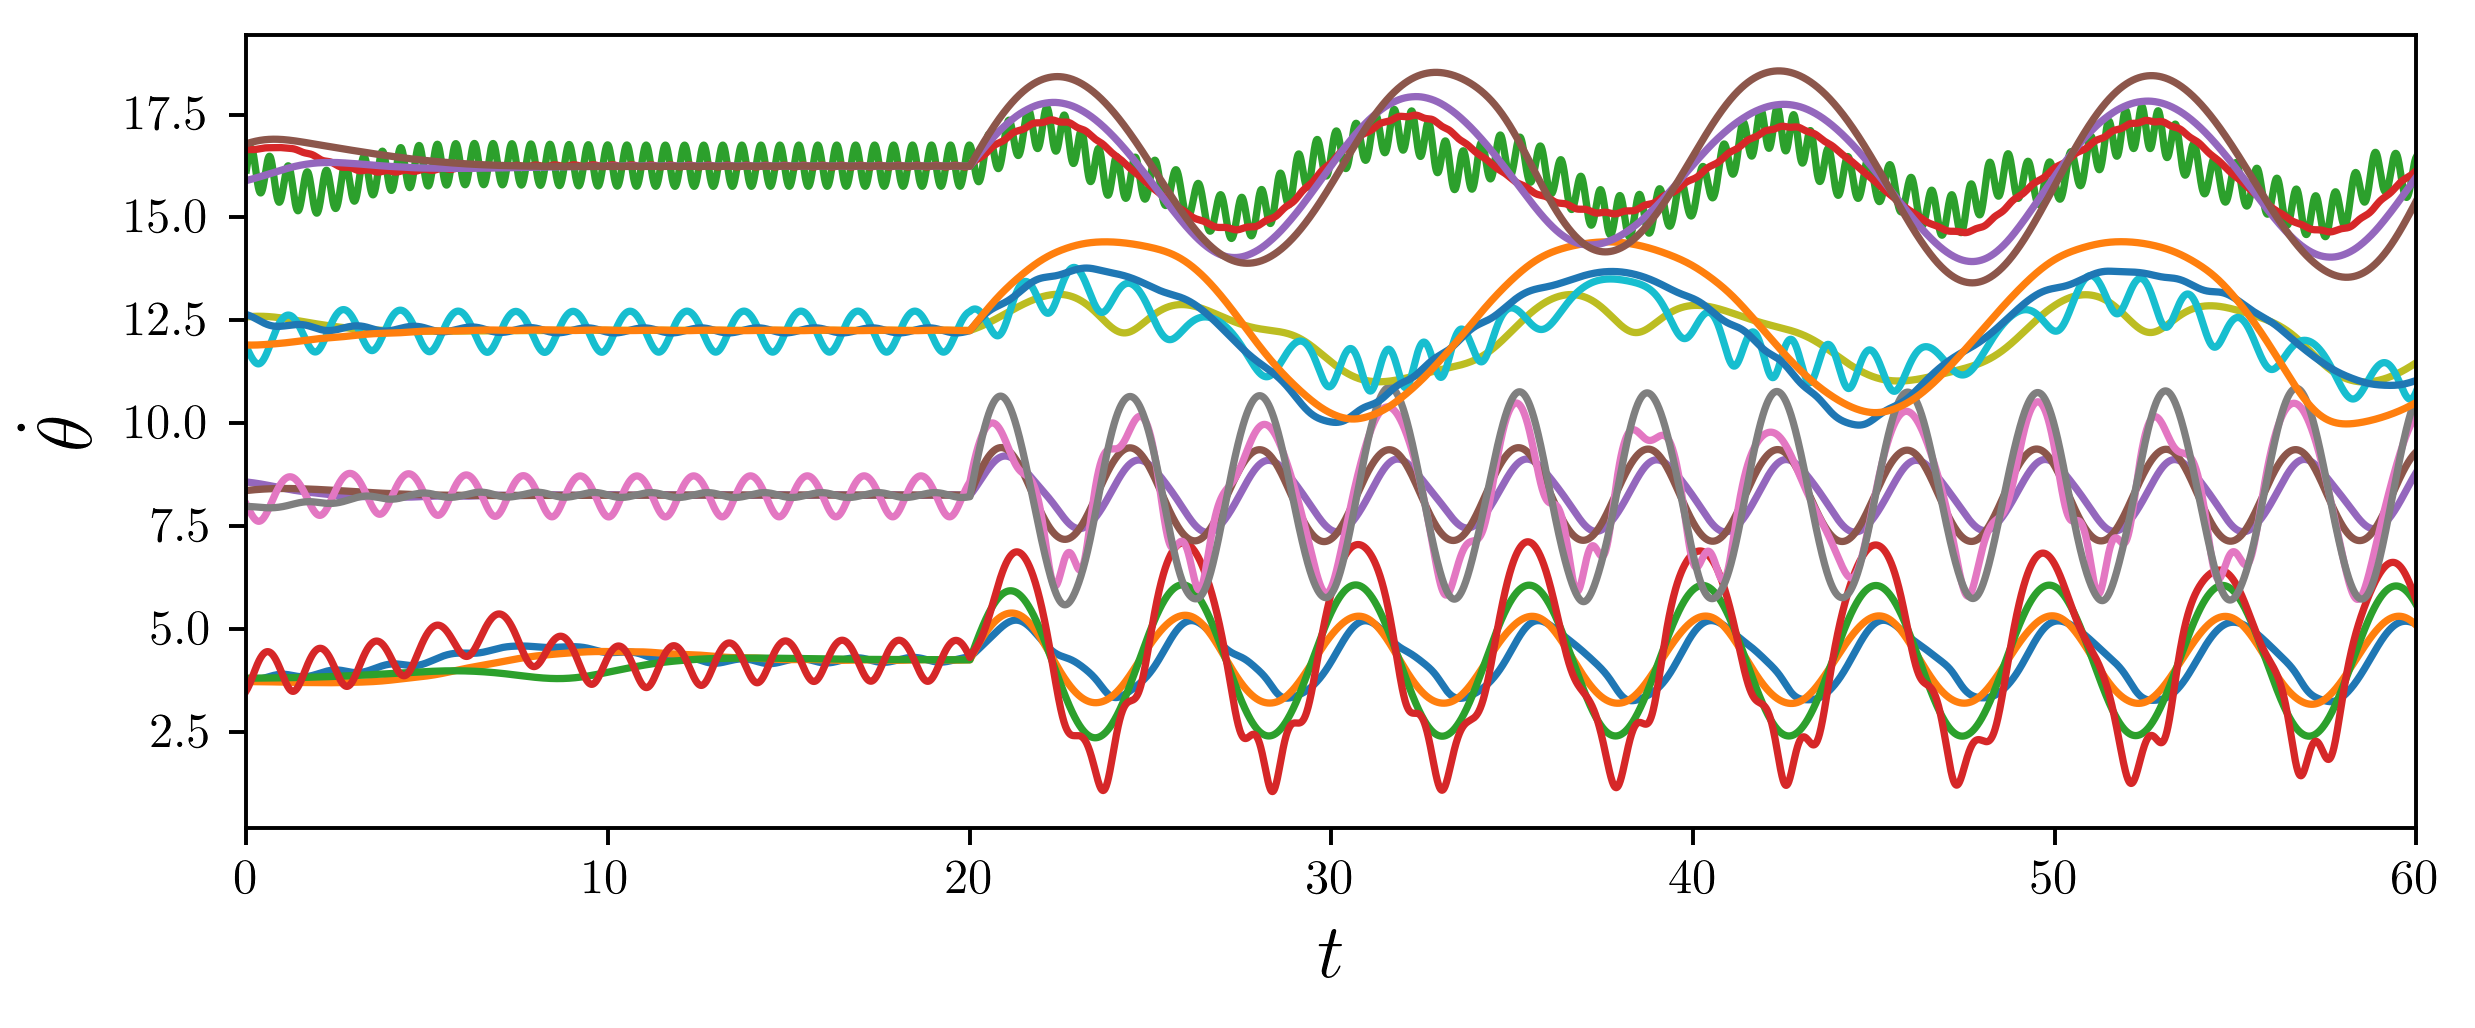

In [8]:
## Plot theta dot

plt.figure(figsize=(8, 3), dpi=350)
for i in range(n_agents):
    plt.plot(time_vals, thetas_dot[i], '-')
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$\dot{\theta}$', fontsize=16)
plt.xlim(0, n_it * dt)
plt.show()

0.00020894353838230018


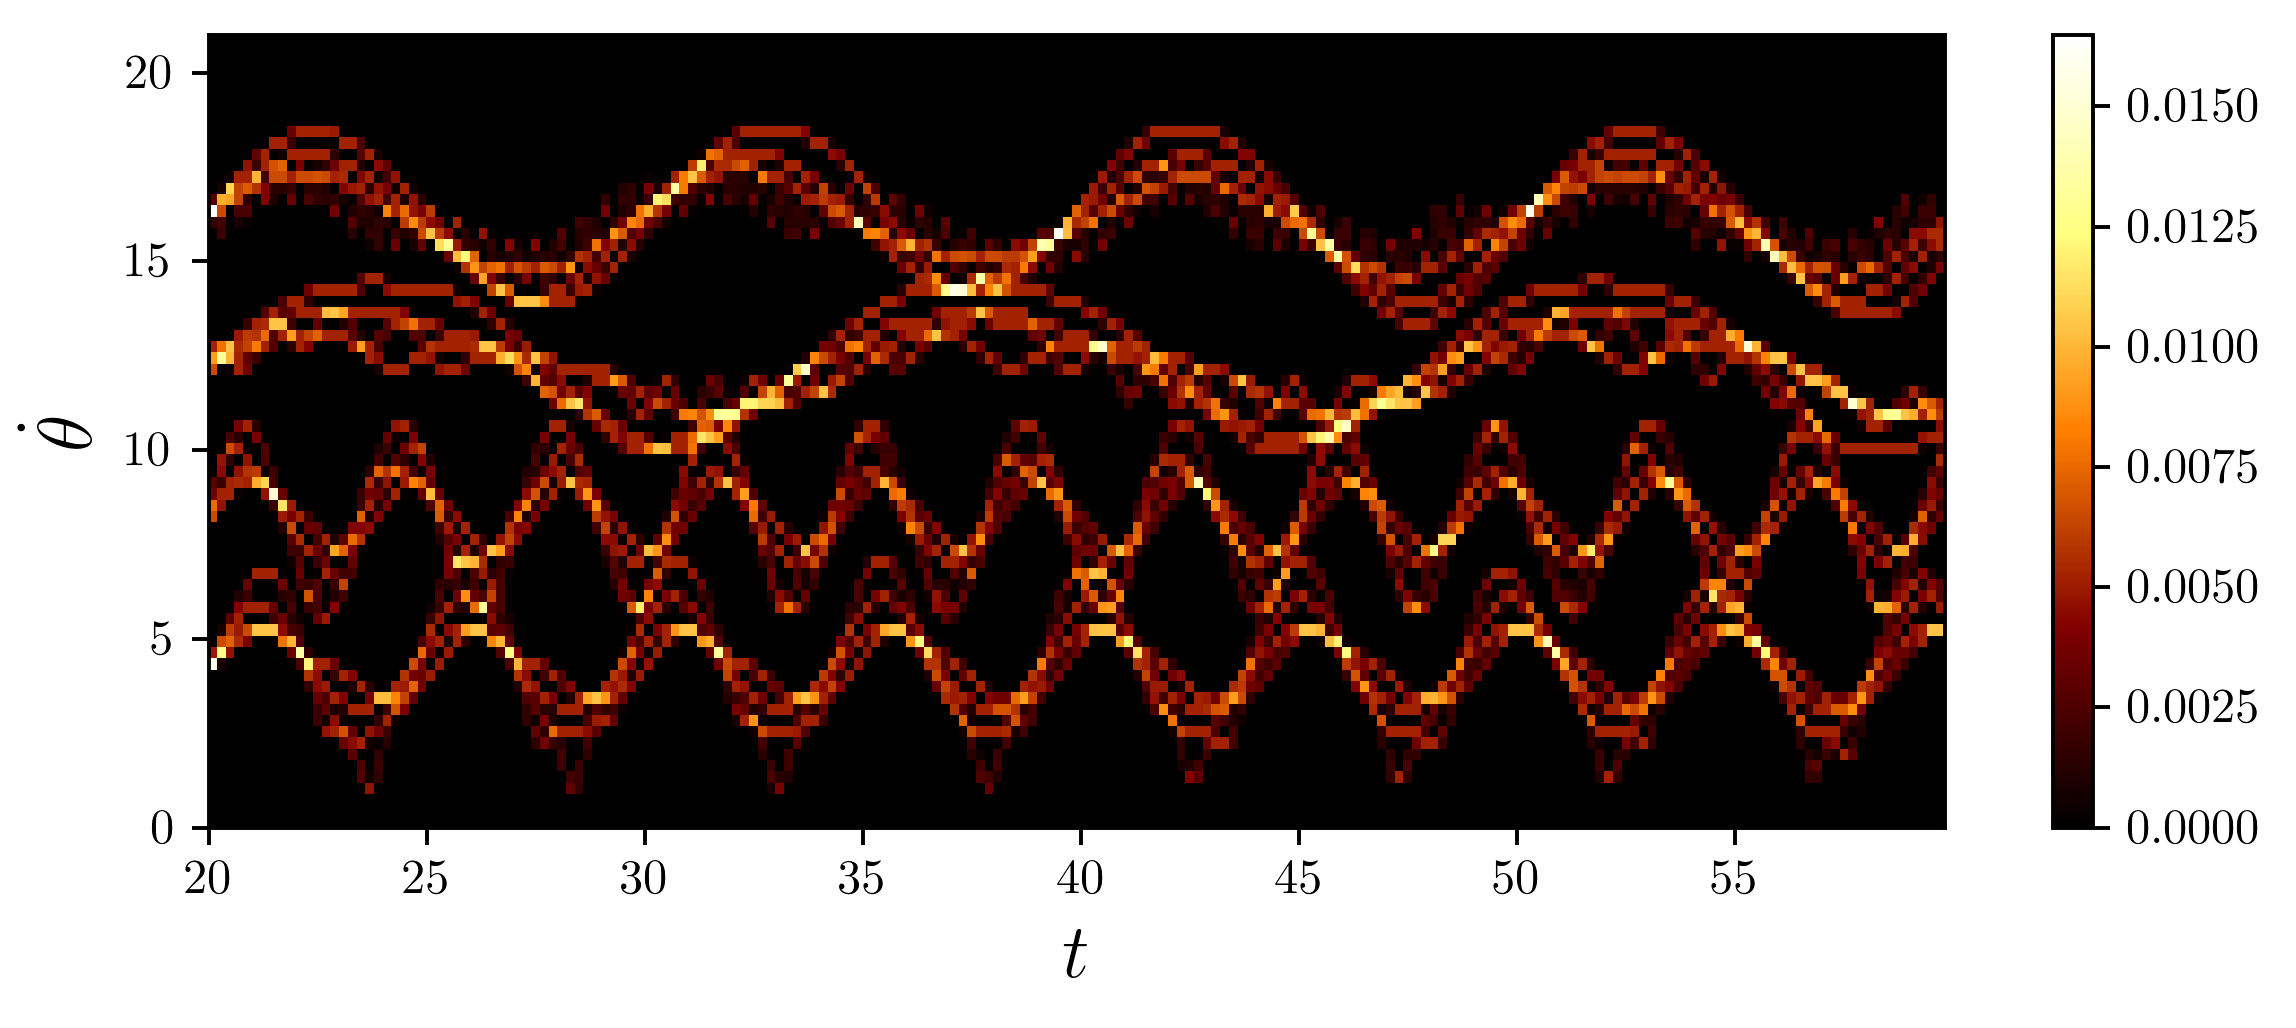

In [18]:
## Space discretization

n_it_bigu = n_it//3
thetas_dot_bigu = thetas_dot[:, n_it_bigu:]
ag_per_clust = n_agents // n_clusters
state_diffs_epsilon = {}
for i in range(n_clusters-1):
    state_diffs_epsilon[i] = np.zeros((ag_per_clust*ag_per_clust, n_it-n_it_bigu))


for i in range(n_clusters-1):
    for j in range(ag_per_clust):
        for k in range(ag_per_clust):
            state_diffs_epsilon[i][j*ag_per_clust + k] = \
                np.abs(thetas_dot_bigu[i*ag_per_clust+j] - thetas_dot_bigu[(i+1)*ag_per_clust+k])

min_epss = []
for i in range(n_clusters-1):
    min_epss.append(np.min(state_diffs_epsilon[i]))
min_eps = np.min(np.array(min_epss))
print(min_eps)
#print(0.3*70)

thd_max = 21.
thd_samples = 70
binx = np.arange(sim_time//3, sim_time, 0.2)
biny = np.linspace(0., thd_max, thd_samples+1)
time_vals_bigu_flat = np.tile(np.linspace(sim_time//3, sim_time, n_it-n_it_bigu), n_agents)
thetas_dot_bigu_flat = thetas_dot_bigu.flatten()

plt.figure(figsize=(8, 3), dpi=350)
thd_hist, _, _, _ = plt.hist2d(time_vals_bigu_flat, thetas_dot_bigu_flat, density=True, bins=[binx, biny], cmap='afmhot')
thd_hist = thd_hist.T
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$\dot{\theta}$', fontsize=16)
cbar = plt.colorbar()
#plt.plot(thetas_dot_bigu_flat)
plt.show()

In [19]:
## Sparsity

print(np.sum(thd_hist == 0.) / thd_hist.size)

0.7063173007896626


In [23]:
## CS compress

# find m
thd_hist_flat = thd_hist.flatten()
cs_n = thd_hist.size
discrete_times = thd_hist.shape[1]
print(cs_n)
#print(discrete_times)

cs_s = cs_n - np.sum(thd_hist == 0.)
#print(cs_s)

cs_m = int(1 * cs_s)
print(cs_m)

# compress
phi_mat = np.random.randn(cs_m, cs_n) * 1/cs_m
compressed_data = np.dot(phi_mat, thd_hist_flat)

13930
4091


In [24]:
## CS decompress

import scipy.optimize as so
thd_hist_decomp = so.linprog(c=np.ones(cs_n), A_eq=phi_mat, b_eq=compressed_data)['x']

MemoryError: Unable to allocate 435. MiB for an array with shape (4091, 13930) and data type float64

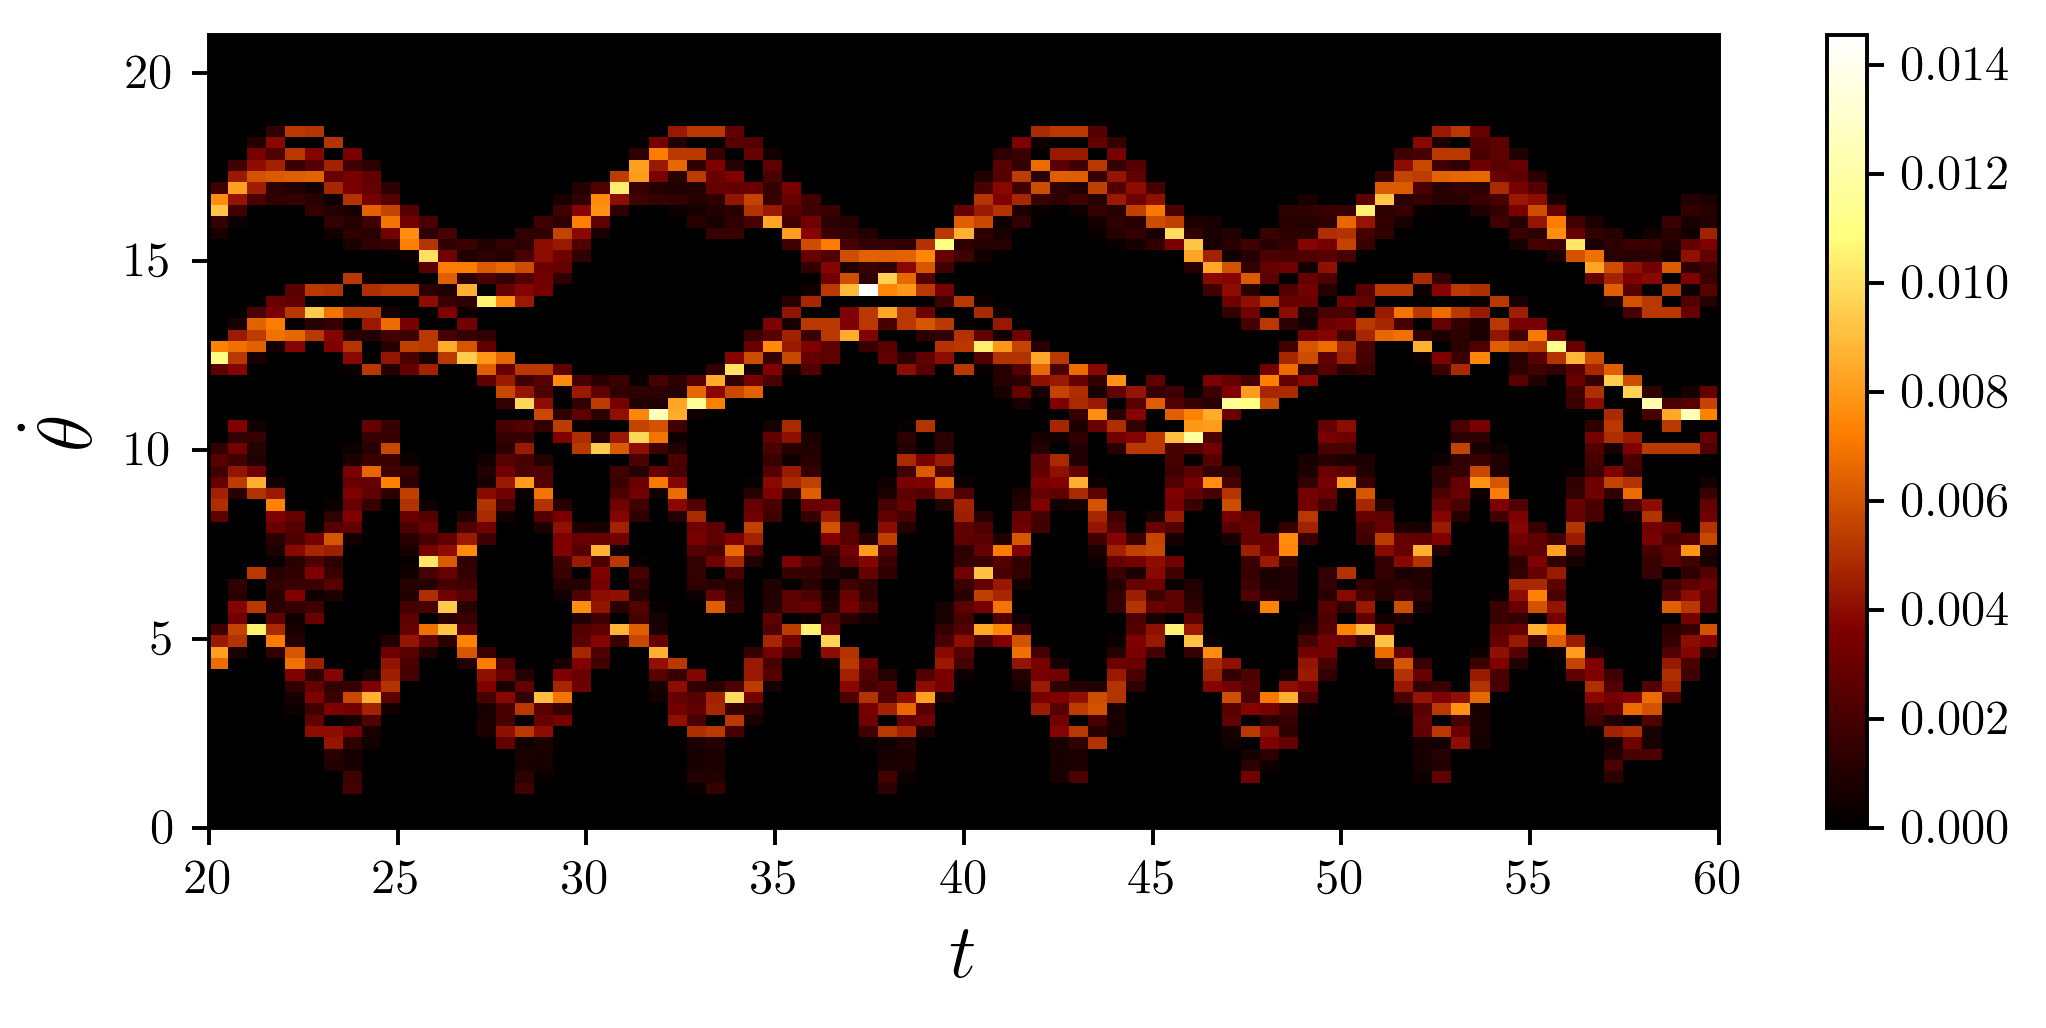

In [13]:
plt.figure(figsize=(8, 3), dpi=350)
plt.imshow(thd_hist_decomp, origin='lower', cmap='afmhot', extent=[sim_time//3, sim_time, 0, thd_max])
cbar = plt.colorbar()
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$\dot{\theta}$', fontsize=16)
plt.show()

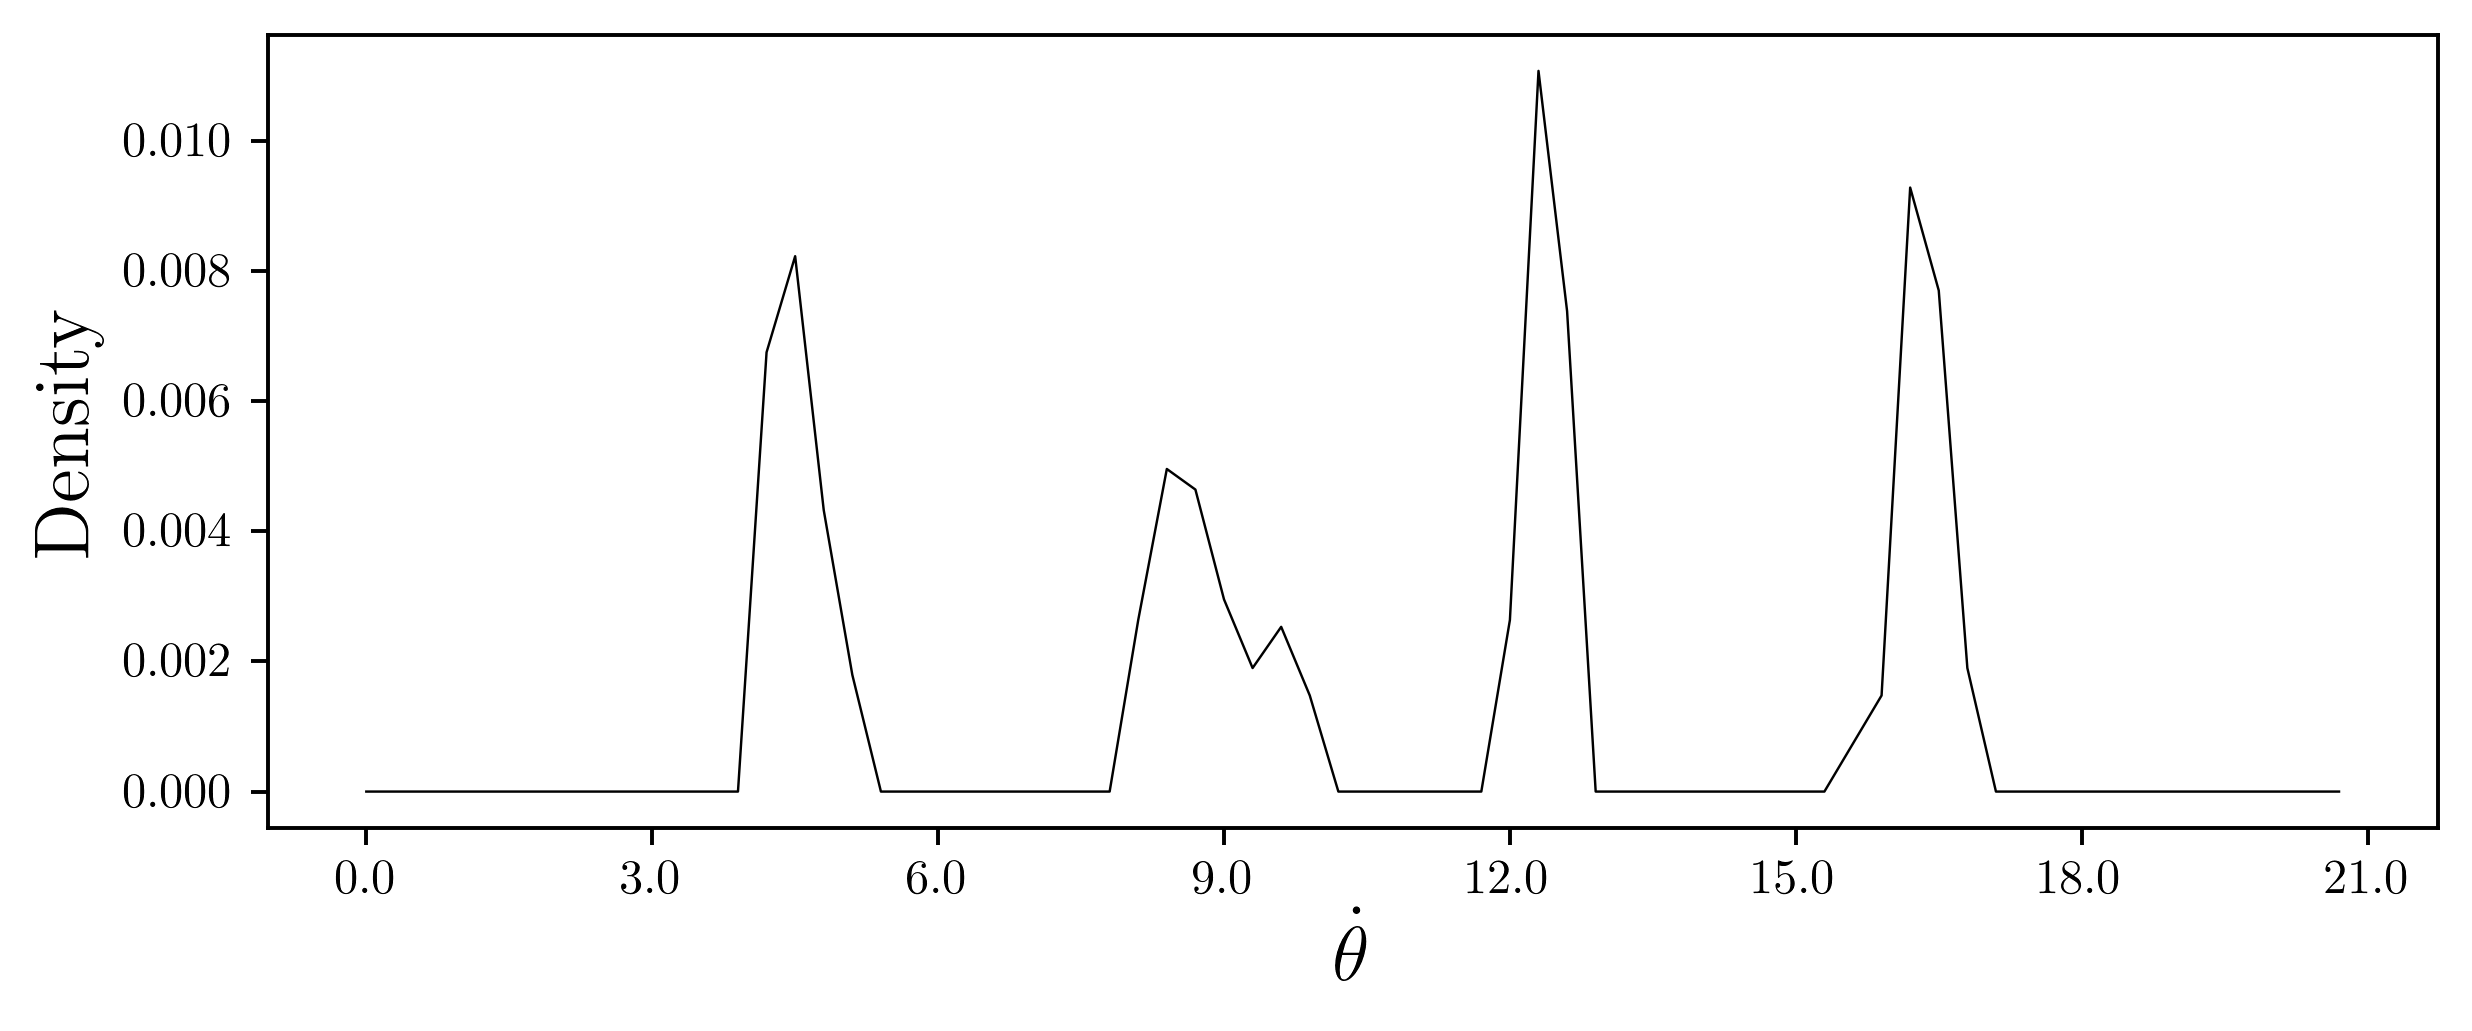

In [14]:
plt.figure(figsize=(8, 3), dpi=350)
plt.plot(thd_hist_decomp[:, 0], color='k', linewidth=0.5)
plt.xlabel(r'$\dot{\theta}$', fontsize=16)
plt.ylabel(r'Density', fontsize=16)
plt.xticks(np.arange(0., thd_samples+1, 10), biny[::10])
plt.show()